#### Figure 1 节点邻居数分布，HGNN和我们方法的效果对比

In [1]:
from __future__ import division
from __future__ import print_function
import argparse
import numpy as np
import scipy.sparse as sp
import torch
import sys
import copy
import random
import torch.nn.functional as F
import torch.optim as optim
import hgnn_cvae_pretrain_new_cora
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import time
from copy import deepcopy
# from config import config
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, f1_score
from dhg import Hypergraph
from dhg.data import *
from dhg.models import *
from dhg.random import set_seed
from sklearn.model_selection import train_test_split

from hgcn.models import HGNN, LAHGCN
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from dhg import Hypergraph
from dhg.data import *
# from data_load_utils import *
# from dhg.models import HGNN, LAHGCN
# from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator

from utils import accuracy, normalize_features, micro_f1, macro_f1, sparse_mx_to_torch_sparse_tensor, normalize_adj
from hgcn import *
from hgcn.models import HGNN, LAHGCN
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
exc_path = sys.path[0]
import os, torch, numpy as np
import hgnn_cvae_pretrain_new_coauthorcora
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


/users/Min/miniconda/envs/hy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
data = CocitationCiteseer()
G = Hypergraph(data["num_vertices"], data["edge_list"])
print('hypergraph:', G)


A = G.H @ G.H.T
print('adjacent matrix:', A)

# 将稀疏张量转换为标准的邻接矩阵表示
adj_matrix = torch.sparse_coo_tensor(A.indices(), A.values(), A.size())

# 计算每个节点的度（关联的邻居节点数）
degree_list = adj_matrix.to_dense().sum(dim=1)
degree_list = degree_list.cpu().numpy().tolist()
degree_list = [int(i) for i in degree_list]

min(degree_list), max(degree_list), sum(degree_list)/len(degree_list)

hypergraph: Hypergraph(num_v=3312, num_e=1004)
adjacent matrix: tensor(indices=tensor([[   0,    0,    0,  ..., 3305, 3305, 3305],
                       [ 540,  290,  691,  ..., 3021, 2654, 2169]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(3312, 3312), nnz=10072, layout=torch.sparse_coo)


(0, 449, 4.488224637681159)

In [10]:
# # 移除孤立节点0
# remove_index = [i for i,e in enumerate(degree_list) if e == 0]

# remove_index[:10], len(remove_index), len(degree_list)-len(remove_index)

([7, 10, 15, 17, 19, 26, 36, 38, 42, 43], 1854, 1458)

In [21]:
# # 设置随机种子，以确保结果可复现
random_seed = 42

# node_idx = [i for i in range(data['num_vertices']) if i not in remove_index]

node_idx = [i for i in range(data['num_vertices'])]
labels = data["labels"][node_idx]
y = list(labels.numpy())
print('节点数：', len(node_idx), len(y))

X = data["features"][node_idx,:]
lbls = data["labels"][y]
print('X dim:', X.shape)
print('labels:', len(torch.unique(lbls)))

degree_list = [degree_list[i] for i in node_idx]

# def map_to_continuous(lst):
#     unique_values = list(set(lst))
#     value_to_index = {value: index for index, value in enumerate(sorted(unique_values))}
#     mapped_lst = [value_to_index[value] for value in lst]
#     return mapped_lst

# node_idx = map_to_continuous(node_idx)
# print('节点：', max(node_idx))

# 将idx_test划分为训练（80%）、验证（10%）和测试（10%）集
idx_train, idx_temp, train_y, tem_y = train_test_split(node_idx, y, test_size=0.2, random_state=random_seed, stratify=y)
idx_val, idx_test, val_y, test_y = train_test_split(idx_temp, tem_y, test_size=0.5, random_state=random_seed, stratify=tem_y)

# 确保划分后的集合没有重叠
assert len(set(idx_train) & set(idx_val)) == 0
assert len(set(idx_train) & set(idx_test)) == 0
assert len(set(idx_val) & set(idx_test)) == 0

train_mask = torch.zeros(len(node_idx), dtype=torch.bool)
val_mask = torch.zeros(len(node_idx), dtype=torch.bool)
test_mask = torch.zeros(len(node_idx), dtype=torch.bool)
train_mask[idx_train] = True
val_mask[idx_val] = True
test_mask[idx_test] = True

set_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

net = HGNN(X.shape[1], 64, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbls = X.to(device), lbls.to(device)
G = G.to(device)
net = net.to(device)

节点数： 3312 3312
X dim: torch.Size([3312, 3703])
labels: 4


In [22]:
min(degree_list), max(degree_list),sum(degree_list)/len(degree_list)

(0, 449, 4.488224637681159)

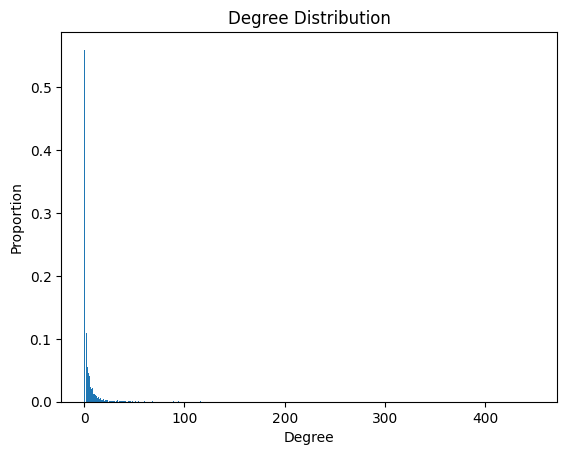

In [23]:
import matplotlib.pyplot as plt
from collections import Counter

# 使用Counter计算值的分布
degree_distribution = Counter(degree_list)

# 提取度数和对应的出现次数
degrees, counts = zip(*degree_distribution.items())

# 计算占比
total_counts = sum(counts)
proportions = [count / total_counts for count in counts]

# 创建柱状图
plt.bar(degrees, proportions, align='center')

# 添加标签和标题
plt.xlabel('Degree')
plt.ylabel('Proportion')
plt.title('Degree Distribution')

# 显示图形
plt.show()


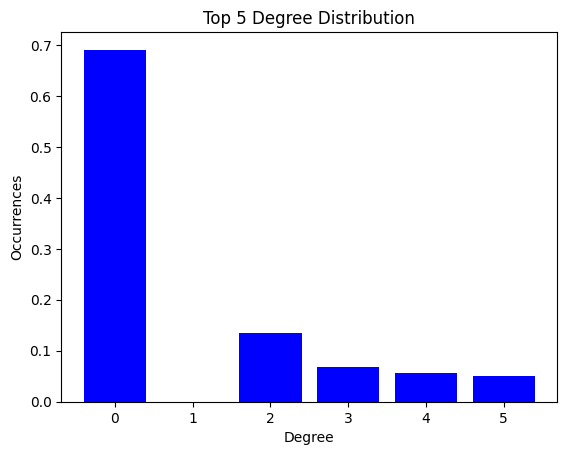

In [24]:
# 获取排名前5的度数和对应的出现次数
top_degrees = sorted(degree_distribution.items(), key=lambda x: x[1], reverse=True)[:5]
top_degrees, top_counts = zip(*top_degrees)



# 计算占比
top_total_counts = sum(top_counts)
top_proportions = [count / top_total_counts for count in top_counts]


# 创建柱状图
plt.bar(top_degrees, top_proportions, color='blue', align='center')

# 添加标签和标题
plt.xlabel('Degree')
plt.ylabel('Occurrences')
plt.title('Top 5 Degree Distribution')

# 显示图形
plt.show()

In [5]:
net.load_state_dict(torch.load('model/hgnn_cocitationciteseer_hid64_2hop.pth'))
net

HGNN(
  (layers): ModuleList(
    (0): HGNNConv(
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=3703, out_features=64, bias=True)
    )
    (1): HGNNConv(
      (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=64, out_features=6, bias=True)
    )
  )
)

In [6]:
#Validate and Test
net.eval()
output = net(X, G)


outs, lbl = output[idx_test], labels[idx_test]

output = torch.log_softmax(output, dim=1)

# Calculate accuracy
_, predicted = torch.max(outs, 1)
# 将predicted结果转换为numpy数组
predicted_array = predicted.cpu().numpy()

# 保存到文件
np.savetxt('res/hgnn_test_cocitationciteseer_hid64_2hop_0104.txt', predicted_array, fmt='%d')

In [7]:
# 从文件中读取预测结果
predicted_array = np.loadtxt('res/hgnn_test_cocitationciteseer_hid64_2hop_0104.txt', dtype=int)
# 将numpy数组转换为列表
predicted_labels = predicted_array.tolist()
true_labels = lbls[test_mask].cpu().numpy().tolist()


predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
# 计算每个节点的True and False Predictions
trues = (predicted_labels == true_labels).astype(int)
errors = [1 if value == 0 else 0 for value in trues]

degree_counts = {}
filtered_data = [(degree, value1, value2) for degree, value1, value2 in zip(degree_list, trues, errors) if 2 <= degree <= 4]

# Populate the dictionary
for degree, value1, value2 in filtered_data:
    if degree not in degree_counts:
        degree_counts[degree] = {'ones': 0, 'zeros': 0, 'total': 0}
    degree_counts[degree]['ones'] += value1
    degree_counts[degree]['zeros'] += value2
    degree_counts[degree]['total'] += 1

# Calculate the probabilities
hgnn_degree_probabilities_list1 = [degree_counts.get(degree, {'ones': 0})['ones'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(2,5)]
# hgnn_degree_probabilities_list2 = [degree_counts.get(degree, {'zeros': 0})['zeros'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(1,6)]
hgnn_degree_probabilities_list1

[0.05555555555555555, 0.23529411764705882, 0.1111111111111111]

In [ ]:
remove_index = [i for i,e in enumerate(degree_sequence) if e == 0]

remove_index[:10], len(remove_index), len(degree_sequence)-len(remove_index)